In [3]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
from time import sleep
import seaborn as sns
import re
import copy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from math import ceil
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import ast

# **Web-Scraper Films**

The web scraper was written to update information from the IMDb website and fill in the dataset

In [ ]:
Placeholder=None#To handle missing values when scraping
Headers={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:84.0) Gecko/20100101 Firefox/84.0'}

In [1]:
movie_name=[]
movie_year=[]
movie_rating=[]
movie_votes=[]
movie_metascore=[]
Gross_income=[]
Movie_Runtime=[]
Genre=[]
Age_rated=[]
Directors=[]
Stars=[]
description=[]

In [ ]:
import time
start=time.time()
pages=np.arange(1,10000,50)
for page in pages:
    url=f'https://www.imdb.com/search/title/?title_type=feature&num_votes=10000,&sort=user_rating,desc&start={str(page)}'
    try:
        webpage = requests.get(url, headers=Headers).text
    except requests.exceptions.ConnectionError:
        print(f"Connection error occurred. Retrying after 5 sec")
        time.sleep(5)  # Wait for 5 seconds before retrying
        continue  # Skip the rest of the loop and move to the next page

    # webpage=requests.get(url,headers=Headers).text
    soup=BeautifulSoup(webpage,'lxml')
    movie_data=soup.find_all("div",class_="lister-item mode-advanced")
    print(f"Scraping URL: {url}")

    for movies in movie_data:
        #Movie name
        movie_name.append(movies.h3.a.text.strip())

        #Years
        years=movies.h3.find("span",class_='lister-item-year text-muted unbold').text.strip("()")
        movie_year.append(years)



        #Rating
        rate=movies.find('div', class_ = 'inline-block ratings-imdb-rating').text.replace('\n', '')
        movie_rating.append(rate)

        #Meta Score
        meta = movies.find('span', class_ = 'metascore').text.replace(' ', '') if movies.find('span', class_ = 'metascore') else Placeholder
        movie_metascore.append(meta)

        #Gross income and Votes

        value = movies.find_all('span', attrs = {'name': "nv"})

        vote = value[0].text
        gross = value[1].text if len(value)>1 else Placeholder#handling missing value
        Gross_income.append(gross)
        movie_votes.append(vote)


        #Runtime,Genre and Certificate

        runtime_span = movies.find("span", class_="runtime")
        genre_span = movies.find("span", class_="genre")
        certificate_span = movies.find("span", class_="certificate")

            # Handle missing runtime information
        if runtime_span:
            runtime_text = runtime_span.text.strip('min')
        else:
            runtime_text = Placeholder

            # Handle missing genre information
        if genre_span:
            genre_text = genre_span.text.strip().split(',')
        else:
            genre_text = [Placeholder]

             # Handle missing certificate information
        if certificate_span:
            certificate_text = certificate_span.text.strip()
        else:
            certificate_text = Placeholder


        #Description

        Movie_Runtime.append(runtime_text)
        Genre.append(genre_text)
        Age_rated.append(certificate_text)

        describe = movies.find_all('p', class_ = 'text-muted')
        description_ = describe[1].text.replace('\n', '') if len(describe) >1 else Placeholder
        description.append(description_)


        #Director and Stars using Regex
        Cast = movies.find('p', class_='').text.strip().replace('\n', '')

              # Extract directors and stars using regex patterns
        directors_pattern = r"Directors?:(.*?)(?:\||Stars:|$)"
        stars_pattern = r"Stars:(.*?)(?:\||$)"

              # Extract directors using regex
        directors_match = re.search(directors_pattern, Cast, re.DOTALL)
        directors = [director.strip() for director in directors_match.group(1).split(',')] if directors_match else []

              # Extract stars using regex
        stars_match = re.search(stars_pattern, Cast, re.DOTALL)
        stars = [star.strip() for star in stars_match.group(1).split(',')] if stars_match else []

        Directors.append(directors)
        Stars.append(stars)

end=time.time()
total=end-start
print(total)

In [ ]:
Dataset = pd.DataFrame({
    "Movie Name": movie_name, "Year of Release" : movie_year, "Run Time in minutes": Movie_Runtime,"Movie Rating": movie_rating,"Votes":movie_votes,"MetaScore":movie_metascore,
    "Gross":Gross_income,"Genre":Genre,"Certification":Age_rated,"Director":Directors,"Stars":Stars,"Description":description
})

In [ ]:
data = pd.DataFrame(columns = Dataset.columns, data = copy.deepcopy(Dataset.values))

In [ ]:
data['Year of Release']=data['Year of Release'].str.replace(r'\D', '').astype(int)#Removes all the unwanted values with regex \D  and changes them into int
data.Votes=data.Votes.str.replace(',','').astype(int)
data['Movie Rating']=data['Movie Rating'].astype(float)
data['Run Time in minutes']=data['Run Time in minutes'].astype(int)

for index,value in enumerate(data.Gross):
  if value!=None:
    data.Gross[index]=value.replace('$','').replace('M','')
data.Gross=pd.to_numeric(data.Gross)
data.Gross=data.Gross*1000000

data.MetaScore=pd.to_numeric(data.MetaScore)


In [ ]:
data.info()

In [ ]:
data.to_csv("Movies_IMDB.csv")

# **Lab 1**

Cleaning and front trimming of the data set

### **General Information**

In [ ]:
df = pd.read_csv('Movies_IMDB.csv')

In [ ]:
print(df.shape)

(10000, 13)


In [ ]:
print(df.dtypes)

Unnamed: 0               int64
Movie Name              object
Year of Release          int64
Run Time in minutes      int64
Movie Rating           float64
Votes                    int64
MetaScore              float64
Gross                  float64
Genre                   object
Certification           object
Director                object
Stars                   object
Description             object
dtype: object


In [ ]:
print(df.isnull().sum())

Unnamed: 0                0
Movie Name                0
Year of Release           0
Run Time in minutes       0
Movie Rating              0
Votes                     0
MetaScore              2018
Gross                  2925
Genre                     0
Certification           368
Director                  0
Stars                     0
Description               0
dtype: int64


In [ ]:
df = df.rename(columns={'Unnamed: 0': 'Number'})

In [ ]:
df = df.drop_duplicates()
print(df.shape)

(10000, 13)


**Anomaly**

<Axes: xlabel='Movie Rating'>

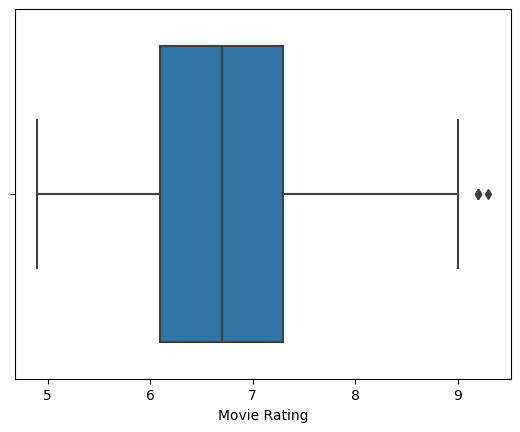

In [ ]:
sns.boxplot(x=df['Movie Rating'])

In [ ]:
result_rating = df[df['Movie Rating'] >= 9.2]
result_rating

,Number,Movie Name,Year of Release,Run Time in minutes,Movie Rating,Votes,MetaScore,Gross,Genre,Certification,Director,Stars,Description
0,0,The Shawshank Redemption,1994,142,9.3,2811615,82.0,28340000.0,['Drama'],R,['Frank Darabont'],"['Tim Robbins', 'Morgan Freeman', 'Bob Gunton'...","Over the course of several years, two convicts..."
1,1,The Godfather,1972,175,9.2,1959442,100.0,134970000.0,"['Crime', ' Drama']",R,['Francis Ford Coppola'],"['Marlon Brando', 'Al Pacino', 'James Caan', '...","Don Vito Corleone, head of a mafia family, dec..."
2,2,Ramayana: The Legend of Prince Rama,1993,135,9.2,13111,NaN,NaN,"['Animation', ' Action', ' Adventure']",PG,"['Ram Mohan', 'Yûgô Sakô', 'Koichi Saski']","['Arun Govil', 'Nikhil Kapoor', 'Edie Mirman',...",An anime adaptation of the Hindu epic the Rama...
3,3,The Chaos Class,1975,87,9.2,42284,NaN,NaN,"['Comedy', ' Drama']",NaN,['Ertem Egilmez'],"['Kemal Sunal', 'Münir Özkul', 'Halit Akçatepe...","Lazy, uneducated students share a very close b..."


<Axes: xlabel='MetaScore'>

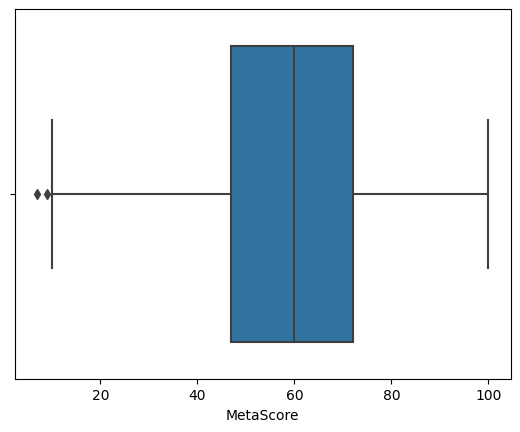

In [ ]:
sns.boxplot(x=df['MetaScore'])

In [ ]:
result_metascore = df[df['MetaScore'] < 10]
result_metascore

,Number,Movie Name,Year of Release,Run Time in minutes,Movie Rating,Votes,MetaScore,Gross,Genre,Certification,Director,Stars,Description
9846,9846,Saturn 3,1980,88,5.1,10198,9.0,NaN,"['Adventure', ' Horror', ' Sci-Fi']",R,"['Stanley Donen', 'John Barry']","['Farrah Fawcett', 'Kirk Douglas', 'Harvey Kei...",Two lovers stationed at a remote base in the a...
9941,9941,Miss March,2009,90,5.0,22103,7.0,4540000.0,"['Comedy', ' Romance']",R,"['Zach Cregger', 'Trevor Moore']","['Zach Cregger', 'Trevor Moore', 'Raquel Aless...",Eugene believes in no sex before marriage. So ...


<Axes: xlabel='Votes'>

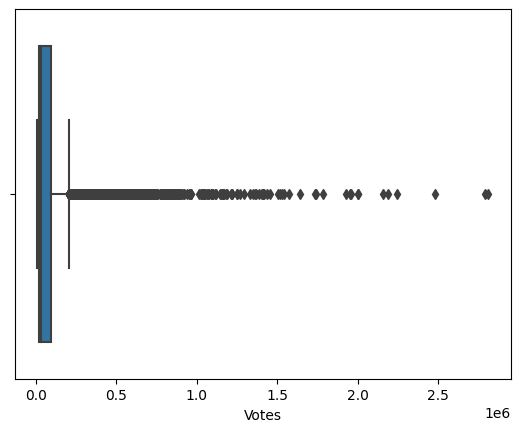

In [ ]:
sns.boxplot(x=df['Votes'])

In [ ]:
result_votes = df[df['Votes'] > 300000]
print(result_votes.shape)

(667, 13)


## **Empty Values**

### **Check empty values**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Number               10000 non-null  int64  
 1   Movie Name           10000 non-null  object 
 2   Year of Release      10000 non-null  int64  
 3   Run Time in minutes  10000 non-null  int64  
 4   Movie Rating         10000 non-null  float64
 5   Votes                10000 non-null  int64  
 6   MetaScore            7982 non-null   float64
 7   Gross                7075 non-null   float64
 8   Genre                10000 non-null  object 
 9   Certification        9632 non-null   object 
 10  Director             10000 non-null  object 
 11  Stars                10000 non-null  object 
 12  Description          10000 non-null  object 
dtypes: float64(3), int64(4), object(6)
memory usage: 1.1+ MB


In [ ]:
null_meta = df[df['MetaScore'].isnull()]
null_meta

,Number,Movie Name,Year of Release,Run Time in minutes,Movie Rating,Votes,MetaScore,Gross,Genre,Certification,Director,Stars,Description
2,2,Ramayana: The Legend of Prince Rama,1993,135,9.2,13111,NaN,NaN,"['Animation', ' Action', ' Adventure']",PG,"['Ram Mohan', 'Yûgô Sakô', 'Koichi Saski']","['Arun Govil', 'Nikhil Kapoor', 'Edie Mirman',...",An anime adaptation of the Hindu epic the Rama...
3,3,The Chaos Class,1975,87,9.2,42284,NaN,NaN,"['Comedy', ' Drama']",NaN,['Ertem Egilmez'],"['Kemal Sunal', 'Münir Özkul', 'Halit Akçatepe...","Lazy, uneducated students share a very close b..."
9,9,Mirror Game,2016,147,9.0,29167,NaN,NaN,"['Crime', ' Mystery', ' Thriller']",NaN,['Amitabh Reza Chowdhury'],"['Chanchal Chowdhury', 'Masuma Rahman Nabila',...",A struggling actor becomes a professional impo...
10,10,Daman,2022,121,9.0,13465,NaN,NaN,"['Adventure', ' Drama']",NaN,"['Lenka Debiprasad', 'Vishal Mourya']","['Karan Kandhapan', 'Babushan Mohanty', 'Dipan...","The film is set in 2015. Sid, is a young docto..."
12,12,Demon Slayer: Kimetsu no Yaiba - Tsuzumi Mansi...,2021,87,8.9,22213,NaN,NaN,"['Animation', ' Action', ' Fantasy']",NaN,['Haruo Sotozaki'],[],Tanjiro ventures to the south-southeast where ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9961,9961,Elephant White,2011,91,5.0,11003,NaN,NaN,"['Action', ' Crime', ' Thriller']",R,['Prachya Pinkaew'],"['Kevin Bacon', 'Djimon Hounsou', 'Vithaya Pan...",An assassin is hired by a businessman to aveng...
9963,9963,Jai Ho,2014,135,5.0,20460,NaN,1250000.0,"['Action', ' Drama']",Not Rated,['Sohail Khan'],"['Salman Khan', 'Daisy Shah', 'Tabu', 'Danny D...","An upright ex-army man, Jai fights a solitary ..."
9969,9969,Survival Island,2005,95,4.9,10315,NaN,NaN,"['Drama', ' Thriller']",TV-MA,['Stewart Raffill'],"['Billy Zane', 'Kelly Brook', 'Juan Pablo Di P...",Three people - a rich couple and a crew member...
9988,9988,Nobody Sleeps in the Woods Tonight,2020,102,4.9,13516,NaN,NaN,"['Fantasy', ' Horror', ' Mystery']",TV-MA,['Bartosz M. Kowalski'],"['Julia Wieniawa-Narkiewicz', 'Michal Lupa', '...",A group of technology-dependent teenagers goes...


In [ ]:
null_gross = df[df['Gross'].isnull()]
null_gross

,Number,Movie Name,Year of Release,Run Time in minutes,Movie Rating,Votes,MetaScore,Gross,Genre,Certification,Director,Stars,Description
2,2,Ramayana: The Legend of Prince Rama,1993,135,9.2,13111,NaN,NaN,"['Animation', ' Action', ' Adventure']",PG,"['Ram Mohan', 'Yûgô Sakô', 'Koichi Saski']","['Arun Govil', 'Nikhil Kapoor', 'Edie Mirman',...",An anime adaptation of the Hindu epic the Rama...
3,3,The Chaos Class,1975,87,9.2,42284,NaN,NaN,"['Comedy', ' Drama']",NaN,['Ertem Egilmez'],"['Kemal Sunal', 'Münir Özkul', 'Halit Akçatepe...","Lazy, uneducated students share a very close b..."
9,9,Mirror Game,2016,147,9.0,29167,NaN,NaN,"['Crime', ' Mystery', ' Thriller']",NaN,['Amitabh Reza Chowdhury'],"['Chanchal Chowdhury', 'Masuma Rahman Nabila',...",A struggling actor becomes a professional impo...
10,10,Daman,2022,121,9.0,13465,NaN,NaN,"['Adventure', ' Drama']",NaN,"['Lenka Debiprasad', 'Vishal Mourya']","['Karan Kandhapan', 'Babushan Mohanty', 'Dipan...","The film is set in 2015. Sid, is a young docto..."
12,12,Demon Slayer: Kimetsu no Yaiba - Tsuzumi Mansi...,2021,87,8.9,22213,NaN,NaN,"['Animation', ' Action', ' Fantasy']",NaN,['Haruo Sotozaki'],[],Tanjiro ventures to the south-southeast where ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9966,9966,Skinamarink,2022,100,4.9,12943,66.0,NaN,['Horror'],Not Rated,['Kyle Edward Ball'],"['Lucas Paul', 'Dali Rose Tetreault', 'Ross Pa...",Two children wake up in the middle of the nigh...
9969,9969,Survival Island,2005,95,4.9,10315,NaN,NaN,"['Drama', ' Thriller']",TV-MA,['Stewart Raffill'],"['Billy Zane', 'Kelly Brook', 'Juan Pablo Di P...",Three people - a rich couple and a crew member...
9974,9974,There's Someone Inside Your House,2021,96,4.9,18912,45.0,NaN,"['Horror', ' Mystery', ' Thriller']",TV-MA,['Patrick Brice'],"['Sydney Park', 'Théodore Pellerin', 'Asjha Co...",The graduating class at Osborne High is being ...
9982,9982,Awake,2021,96,4.9,24946,35.0,NaN,"['Action', ' Adventure', ' Drama']",TV-MA,['Mark Raso'],"['Gina Rodriguez', 'Ariana Greenblatt', 'Luciu...",After a devastating global event wiped out all...


In [ ]:
null_certifications = df[df['Certification'].isnull()]
null_certifications

,Number,Movie Name,Year of Release,Run Time in minutes,Movie Rating,Votes,MetaScore,Gross,Genre,Certification,Director,Stars,Description
3,3,The Chaos Class,1975,87,9.2,42284,NaN,NaN,"['Comedy', ' Drama']",NaN,['Ertem Egilmez'],"['Kemal Sunal', 'Münir Özkul', 'Halit Akçatepe...","Lazy, uneducated students share a very close b..."
9,9,Mirror Game,2016,147,9.0,29167,NaN,NaN,"['Crime', ' Mystery', ' Thriller']",NaN,['Amitabh Reza Chowdhury'],"['Chanchal Chowdhury', 'Masuma Rahman Nabila',...",A struggling actor becomes a professional impo...
10,10,Daman,2022,121,9.0,13465,NaN,NaN,"['Adventure', ' Drama']",NaN,"['Lenka Debiprasad', 'Vishal Mourya']","['Karan Kandhapan', 'Babushan Mohanty', 'Dipan...","The film is set in 2015. Sid, is a young docto..."
12,12,Demon Slayer: Kimetsu no Yaiba - Tsuzumi Mansi...,2021,87,8.9,22213,NaN,NaN,"['Animation', ' Action', ' Fantasy']",NaN,['Haruo Sotozaki'],[],Tanjiro ventures to the south-southeast where ...
14,14,Tosun Pasa,1976,90,8.9,24192,NaN,NaN,['Comedy'],NaN,['Kartal Tibet'],"['Kemal Sunal', 'Müjde Ar', 'Adile Nasit', 'Se...","Two traditionally rival Turkish families, ""Sef..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9697,9697,Poker Face,2022,94,5.2,11726,43.0,NaN,"['Action', ' Crime', ' Thriller']",NaN,['Russell Crowe'],"['Russell Crowe', 'Liam Hemsworth', 'RZA', 'Ad...",A tech billionaire hosts a high-stakes poker g...
9729,9729,Chernobyl: Abyss,2021,136,5.2,10176,NaN,NaN,"['Drama', ' History']",NaN,['Danila Kozlovskiy'],"['Danila Kozlovskiy', 'Oksana Akinshina', 'Fil...",A story about a heroic fireman who worked as o...
9816,9816,Cannibal Ferox,1981,93,5.1,10537,NaN,NaN,"['Adventure', ' Horror']",NaN,['Umberto Lenzi'],"['Giovanni Lombardo Radice', 'Lorraine De Sell...",Three friends set out to disprove cannibalism ...
9820,9820,10x10,2018,88,5.1,10995,NaN,NaN,"['Drama', ' Mystery', ' Thriller']",NaN,['Suzi Ewing'],"['Kelly Reilly', 'Luke Evans', 'Noel Clarke', ...",A man abducts a flower shop owner and holds he...


### **Certification**

(G - PG - PG-13 - TV-14 - R - NC-17 - Approved)

Filling in and unifying the 'Certification' value for the dataset

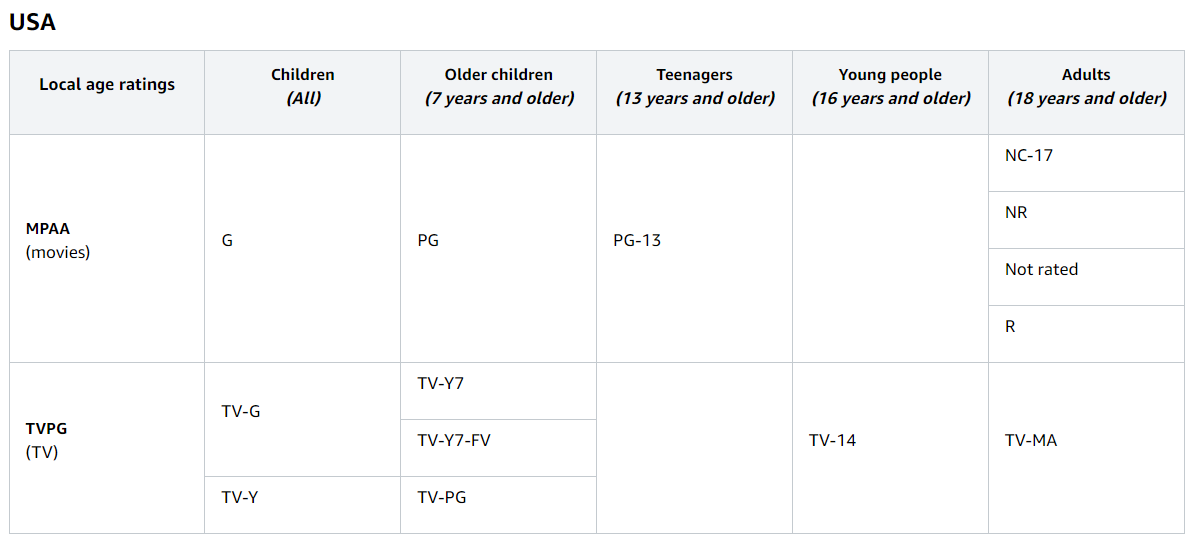

In [ ]:
df['Certification'].unique()

array(['R', 'PG', nan, 'PG-13', 'Approved', 'TV-MA', 'Not Rated', 'G',
       'TV-G', 'Passed', 'TV-13', '18+', 'TV-14', 'Unrated', 'M/PG', 'GP',
       'TV-PG', '16+', 'M', 'NC-17', 'TV-Y7', 'X', '13+', 'MA-17',
       'TV-Y7-FV'], dtype=object)

In [ ]:
df['Certification'] = df['Certification'].fillna('Approved')
df['Certification'] = df['Certification'].replace('TV-MA', 'NC-17')
df['Certification'] = df['Certification'].replace('Not Rated', 'R')
df['Certification'] = df['Certification'].replace('TV-G', 'G')
df['Certification'] = df['Certification'].replace('Passed', 'Approved')
df['Certification'] = df['Certification'].replace('TV-13', 'PG-13')
df['Certification'] = df['Certification'].replace('18+', 'R')
df['Certification'] = df['Certification'].replace('Unrated', 'Approved')
df['Certification'] = df['Certification'].replace('M/PG', 'PG')
df['Certification'] = df['Certification'].replace('GP', 'PG')
df['Certification'] = df['Certification'].replace('TV-PG', 'PG')
df['Certification'] = df['Certification'].replace('16+', 'TV-14')
df['Certification'] = df['Certification'].replace('M', 'PG-13')
df['Certification'] = df['Certification'].replace('TV-Y7', 'PG')
df['Certification'] = df['Certification'].replace('X', 'NC-17')
df['Certification'] = df['Certification'].replace('MA-17', 'NC-17')
df['Certification'] = df['Certification'].replace('13+', 'PG-13')
df['Certification'] = df['Certification'].replace('TV-Y7-FV', 'PG')

In [ ]:
df['Certification'].unique()

array(['R', 'PG', 'Approved', 'PG-13', 'NC-17', 'G', 'TV-14'],
      dtype=object)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Number               10000 non-null  int64  
 1   Movie Name           10000 non-null  object 
 2   Year of Release      10000 non-null  int64  
 3   Run Time in minutes  10000 non-null  int64  
 4   Movie Rating         10000 non-null  float64
 5   Votes                10000 non-null  int64  
 6   MetaScore            7982 non-null   float64
 7   Gross                7075 non-null   float64
 8   Genre                10000 non-null  object 
 9   Certification        10000 non-null  object 
 10  Director             10000 non-null  object 
 11  Stars                10000 non-null  object 
 12  Description          10000 non-null  object 
dtypes: float64(3), int64(4), object(6)
memory usage: 1.1+ MB


### **Metascore rating**

Filling in and unifying the 'MetaScore' value for the dataset using a machine learning model

In [ ]:
train_data_metascore = df[df['MetaScore'].notnull()]

In [ ]:
test_data_metascore = df[df['MetaScore'].isnull()]

In [ ]:
features_metascore = ['Movie Rating', 'Year of Release', 'Votes', 'Run Time in minutes']

In [ ]:
X_train_metascore = train_data_metascore[features_metascore]
Y_train_metascore = train_data_metascore['MetaScore']
X_test_metascore = test_data_metascore[features_metascore]

In [ ]:
model_metascore = RandomForestRegressor(n_estimators=100, random_state = 0)

In [ ]:
model_metascore.fit(X_train_metascore, Y_train_metascore)

RandomForestRegressor(random_state=0)

In [ ]:
predict_metascore = model_metascore.predict(X_test_metascore)

In [ ]:
test_data_metascore['new MetaScore'] = predict_metascore

<ipython-input-26-857ae76f4a44>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_metascore['new MetaScore'] = predict_metascore


In [ ]:
test_data_metascore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2018 entries, 2 to 9999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Number               2018 non-null   int64  
 1   Movie Name           2018 non-null   object 
 2   Year of Release      2018 non-null   int64  
 3   Run Time in minutes  2018 non-null   int64  
 4   Movie Rating         2018 non-null   float64
 5   Votes                2018 non-null   int64  
 6   MetaScore            0 non-null      float64
 7   Gross                599 non-null    float64
 8   Genre                2018 non-null   object 
 9   Certification        2018 non-null   object 
 10  Director             2018 non-null   object 
 11  Stars                2018 non-null   object 
 12  Description          2018 non-null   object 
 13  new MetaScore        2018 non-null   float64
dtypes: float64(4), int64(4), object(6)
memory usage: 236.5+ KB


In [ ]:
for index, row in df.iterrows():
  metaScore = row['Movie Name']
  new_metaScore = test_data_metascore[test_data_metascore['Movie Name'] == metaScore]

  if not new_metaScore.empty:
    if pd.isna(row['MetaScore']):
      meta = new_metaScore.iloc[0]['new MetaScore']
      df.at[index, 'MetaScore'] = meta

In [ ]:
df['MetaScore'] = df['MetaScore'].round(0)

In [ ]:
df

In [ ]:
df.info()

### **Gross**

Filling in and unifying the 'Gross' value for the dataset using other datasets



### Filling with the first dataset

In [ ]:
zero_gross = df[df['Gross'] == 0]
print(zero_gross.shape)
print("Zero value sum: " + str((df['Gross'].isnull().sum())))

(1439, 13)
Zero value sum: 1234


In [ ]:
set_for_gross_first = pd.read_csv('movies_metadata.csv')

<ipython-input-90-428e464edd0a>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  set_for_gross_first = pd.read_csv('movies_metadata.csv')


In [ ]:
set_for_gross_first.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [ ]:
for index, row in df.iterrows():
  name_film = row['Movie Name']
  excerpt = set_for_gross_first[set_for_gross_first['title'] == name_film]

  if not excerpt.empty:
    if pd.isna(row['Gross']) or (row['Gross'] == 0.0):
      gross = excerpt.iloc[0]['revenue']
      df.at[index, 'Gross'] = gross

for index, row in df.iterrows():
  name_film = row['Movie Name']
  excerpt = set_for_gross_first[set_for_gross_first['original_title'] == name_film]

  if not excerpt.empty:
    if (pd.isna(row['Gross'])) or (row['Gross'] == 0.0):
      gross = excerpt.iloc[0]['revenue']
      df.at[index, 'Gross'] = gross

In [ ]:
zero_gross = df[df['Gross'] == 0]
print(zero_gross.shape)
print("Zero value sum: " + str((df['Gross'].isnull().sum())))

(1413, 13)
Zero value sum: 1234


In [ ]:
print(df.isnull().sum())

Number                    0
Movie Name                0
Year of Release           0
Run Time in minutes       0
Movie Rating              0
Votes                     0
MetaScore                 0
Gross                  1234
Genre                     0
Certification             0
Director                  0
Stars                     0
Description               0
dtype: int64


### Filling the secound dataset

In [ ]:
set_for_gross_secound = pd.read_csv('TMDB_movie_dataset_v11.csv')

In [ ]:
set_for_gross_secound.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945123 entries, 0 to 945122
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    945123 non-null  int64  
 1   title                 945112 non-null  object 
 2   vote_average          945123 non-null  float64
 3   vote_count            945123 non-null  int64  
 4   status                945123 non-null  object 
 5   release_date          857525 non-null  object 
 6   revenue               945123 non-null  int64  
 7   runtime               945123 non-null  int64  
 8   adult                 945123 non-null  bool   
 9   backdrop_path         277265 non-null  object 
 10  budget                945123 non-null  int64  
 11  homepage              102996 non-null  object 
 12  imdb_id               555659 non-null  object 
 13  original_language     945123 non-null  object 
 14  original_title        945112 non-null  object 
 15  

In [ ]:
for index, row in df.iterrows():
  name_film = row['Movie Name']
  excerpt = set_for_gross_secound[set_for_gross_secound['title'] == name_film]

  if not excerpt.empty:
    if pd.isna(row['Gross']) or (row['Gross'] == 0.0):
      gross = excerpt.iloc[0]['revenue']
      df.at[index, 'Gross'] = gross

for index, row in df.iterrows():
  name_film = row['Movie Name']
  excerpt = set_for_gross_secound[set_for_gross_secound['original_title'] == name_film]

  if not excerpt.empty:
    if (pd.isna(row['Gross'])) or (row['Gross'] == 0.0):
      gross = excerpt.iloc[0]['revenue']
      df.at[index, 'Gross'] = gross


In [ ]:
zero_gross = df[df['Gross'] == 0]
print(zero_gross.shape)
print("Zero value sum: " + str((df['Gross'].isnull().sum())))

(1692, 13)
Zero value sum: 138


In [ ]:
print(df.isnull().sum())

Number                   0
Movie Name               0
Year of Release          0
Run Time in minutes      0
Movie Rating             0
Votes                    0
MetaScore                0
Gross                  138
Genre                    0
Certification            0
Director                 0
Stars                    0
Description              0
dtype: int64


### Add zeros to Gross

If Gross row has NaN we replace them with zero

In [ ]:
df['Gross'].fillna(0, inplace=True)

In [ ]:
df.isnull().sum()

Number                 0
Movie Name             0
Year of Release        0
Run Time in minutes    0
Movie Rating           0
Votes                  0
MetaScore              0
Gross                  0
Genre                  0
Certification          0
Director               0
Stars                  0
Description            0
dtype: int64

### **Column "Has gross"**

Adding a column with a flag that indicates films who don`t have Gross (it`s a Netflix films, anime etc.)


In [ ]:
df['Has gross'] = df['Gross'] > 0

In [ ]:
df.to_csv('Movies_IMDb_cleaned.csv', index=False)

## **Dataset visualization**

In [5]:
df = pd.read_csv('Movies_IMDb_cleaned.csv')
filtered_data = df[df['Has gross'] == True]

### Certification visualisation

Text(0.5, 1.0, 'Distribution of films by Certifications')

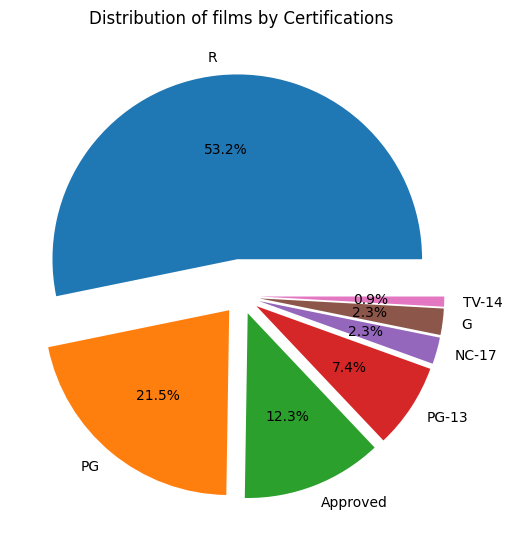

In [6]:
#Certification pie diagramm
certification_count = df['Certification'].value_counts()
certification_labels = df['Certification'].unique().tolist()
explode = [0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

plt.figure(figsize=(6, 6))

plt.pie(certification_count, labels=certification_labels, autopct='%1.1f%%', explode=explode)

plt.title("Distribution of films by Certifications", pad=30)

C:\Users\User\AppData\Local\Temp\ipykernel_9208\53971459.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_years_rounded ['Year rounded'] = (df['Year of Release'] // 10) * 10


Text(167.25, 0.5, 'Certification')

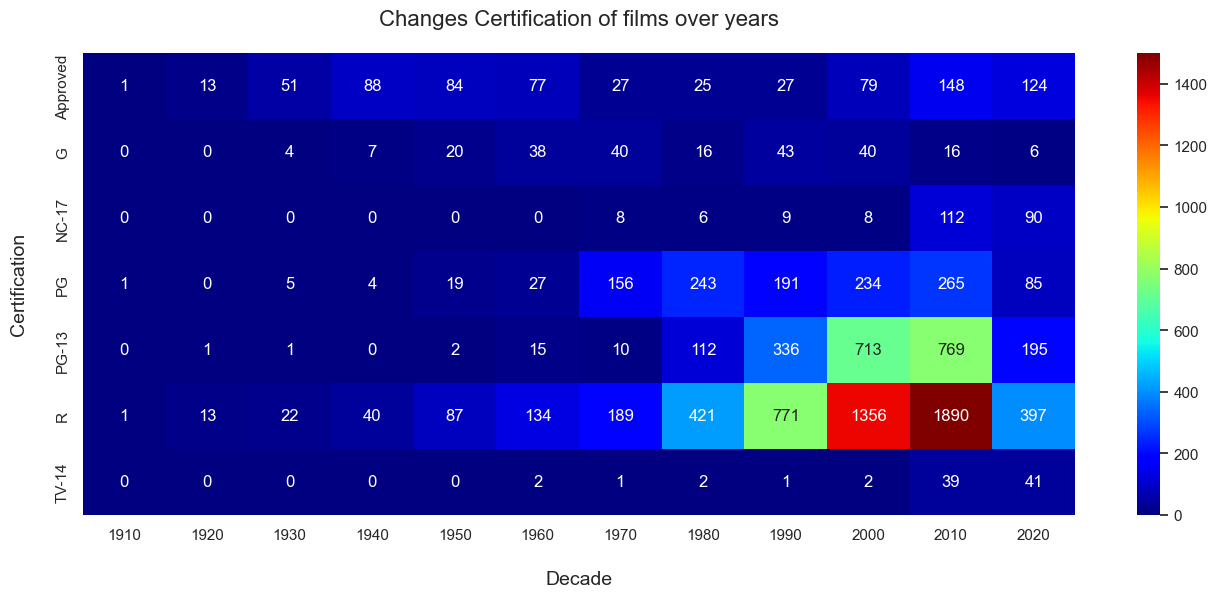

In [7]:
#changes in the Certification of films over the years
sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))

df_years_rounded = df[['Certification', 'Year of Release']]
df_years_rounded ['Year rounded'] = (df['Year of Release'] // 10) * 10
year_certificate_count = df_years_rounded .groupby(['Certification', 'Year rounded']).size().unstack().fillna(0)

sns.heatmap(year_certificate_count, cmap='jet', annot=True, fmt='g', vmax=1500)

plt.title("Changes Certification of films over years", fontsize=16, pad=20)
plt.xlabel('Decade', fontsize=14, labelpad=20)
plt.ylabel('Certification', fontsize=14, labelpad=20)

### Year visualisation

In [ ]:
df_years = df[df['Has gross'] == True]
df_years['Year rounded'] = (df['Year of Release'] // 10) * 10

<ipython-input-302-0a4bf1695c34>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_years['Year rounded'] = (df['Year of Release'] // 10) * 10


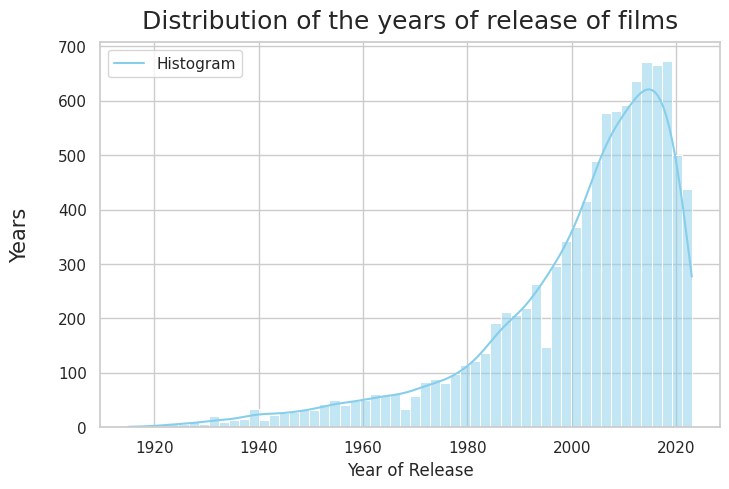

In [ ]:
#number of films per year
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

sns.histplot(df['Year of Release'], kde=True, color="skyblue")

plt.title("Distribution of the years of release of films", fontsize=18, pad=10)
plt.ylabel('Amount of movies',fontsize=15, labelpad=20)
plt.ylabel('Years', fontsize=15, labelpad=20)

plt.legend(["Histogram"], loc="upper left")

(1918.0, 2023.0)

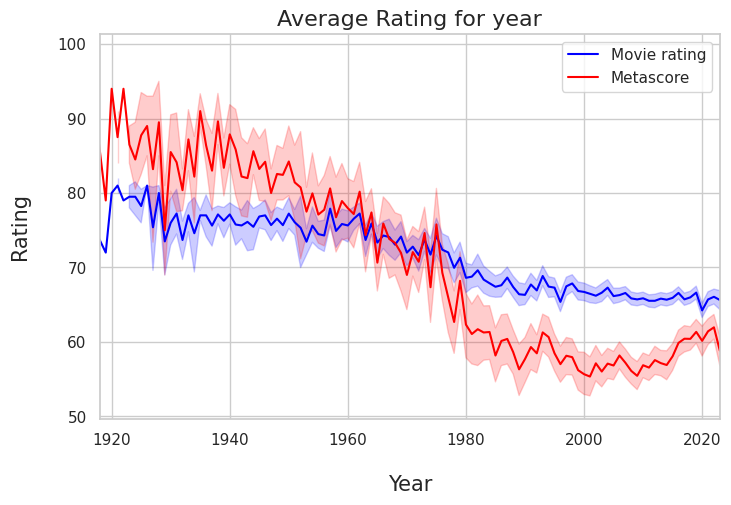

In [ ]:
#Average Rating for year
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

movie_mult_ten = df['Movie Rating'] * 10

sns.lineplot(data=df, x='Year of Release', y=movie_mult_ten, label='Movie rating', color='blue')
sns.lineplot(data=df, x='Year of Release', y='MetaScore', label='Metascore', color='red')

plt.title("Average Rating for year", fontsize=16)
plt.xlabel('Year', fontsize=15, labelpad=20)
plt.ylabel('Rating', fontsize=15, labelpad=20)

plt.xlim(1918, 2023)

<ipython-input-321-fe7c6babb89e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rating['Score Mult'] = df_rating['Movie Rating'] * 10


(70.0, 100.0)

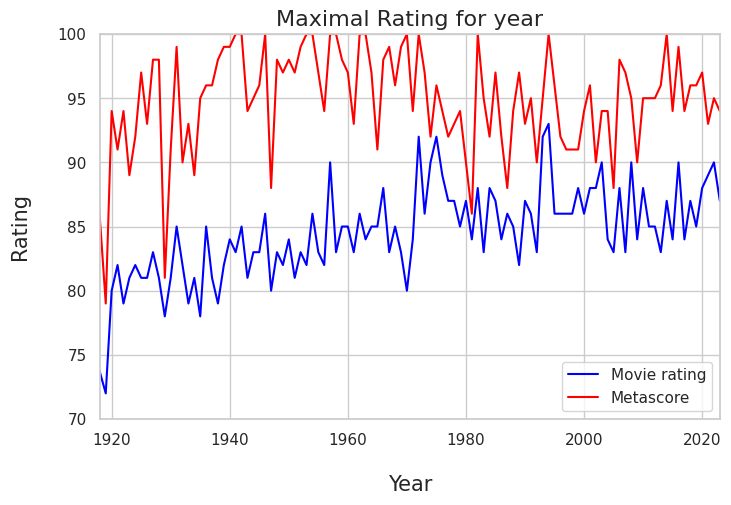

In [ ]:
#maximal Rating for year
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

df_rating = df[['Movie Rating', 'Year of Release']]
df_rating['Score Mult'] = df_rating['Movie Rating'] * 10

max_rating = df_rating.groupby('Year of Release')['Score Mult'].max().reset_index()
max_meta = df.groupby('Year of Release')['MetaScore'].max().reset_index()

sns.lineplot(data=max_rating, x='Year of Release', y='Score Mult', label='Movie rating', color='blue')
sns.lineplot(data=max_meta, x='Year of Release', y='MetaScore', label='Metascore', color='red')

plt.title("Maximal Rating for year", fontsize=16)
plt.xlabel('Year', fontsize=15, labelpad=20)
plt.ylabel('Rating', fontsize=15, labelpad=20)

plt.xlim(1918, 2023)
plt.ylim(70, 100)

Text(0, 0.5, 'Gross')

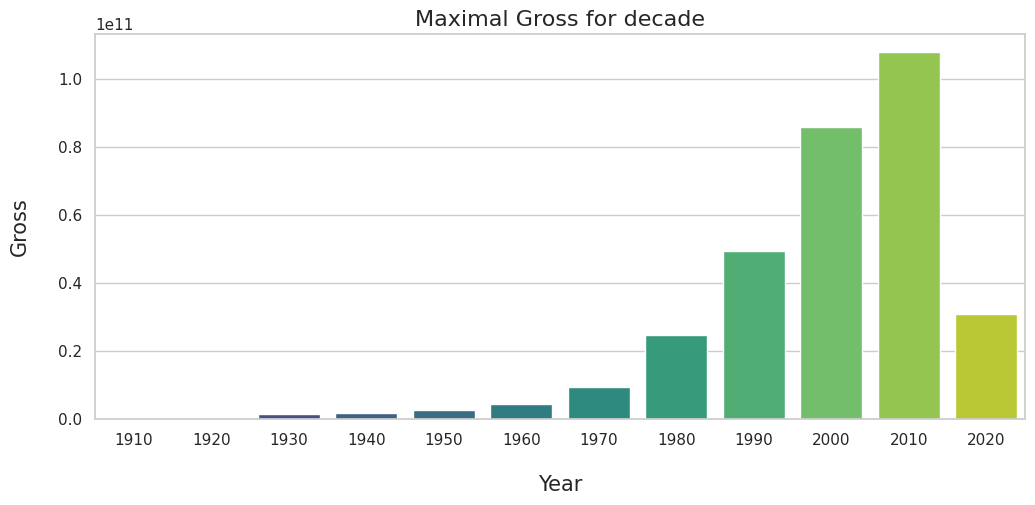

In [ ]:
#maximal Gross for year
sns.set(style="whitegrid")
plt.figure(figsize=(12, 5))

decade_gross = df_years.groupby('Year rounded')['Gross'].sum()

sns.barplot(x=decade_gross.index, y=decade_gross.values, palette='viridis')

plt.title("Maximal Gross for decade", fontsize=16)
plt.xlabel('Year', fontsize=15, labelpad=20)
plt.ylabel('Gross', fontsize=15, labelpad=20)

### Rating and MetaScore visualisation

Text(0, 0.5, 'Count')

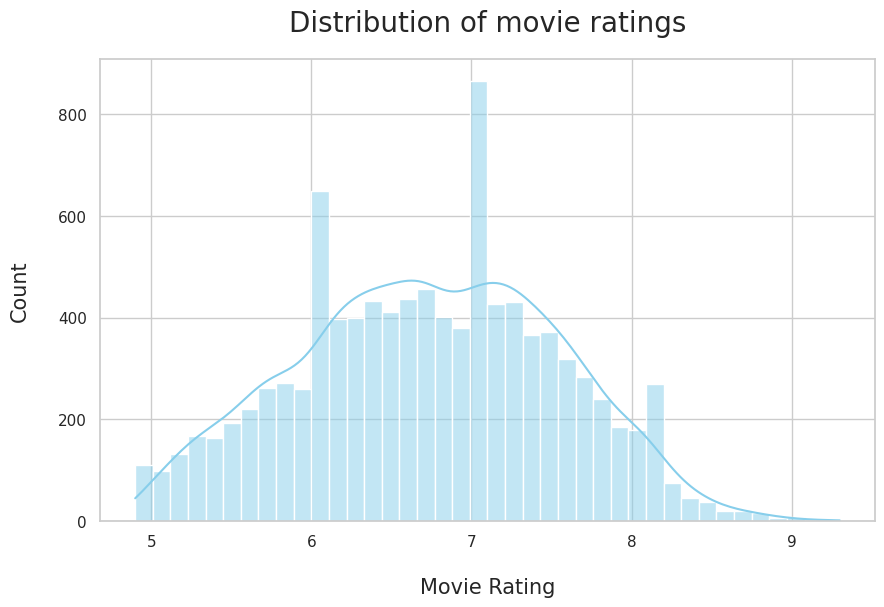

In [ ]:
#number of films per rating value
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.histplot(df['Movie Rating'], kde=True, color='skyblue')

plt.title("Distribution of movie ratings", fontsize=20, pad=20)
plt.xlabel('Movie Rating', fontsize=15, labelpad=20)
plt.ylabel('Count', fontsize=15, labelpad=20)

Text(0, 0.5, 'Count')

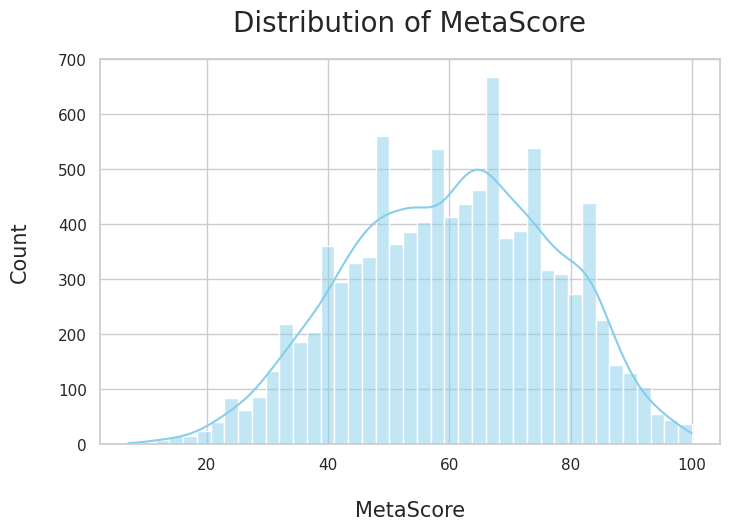

In [347]:
#number of films per rating value
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

sns.histplot(df['MetaScore'], kde=True, color='skyblue')

plt.title("Distribution of MetaScore", fontsize=20, pad=20)
plt.xlabel('MetaScore', fontsize=15, labelpad=20)
plt.ylabel('Count', fontsize=15, labelpad=20)

Text(0, 0.5, 'Gross')

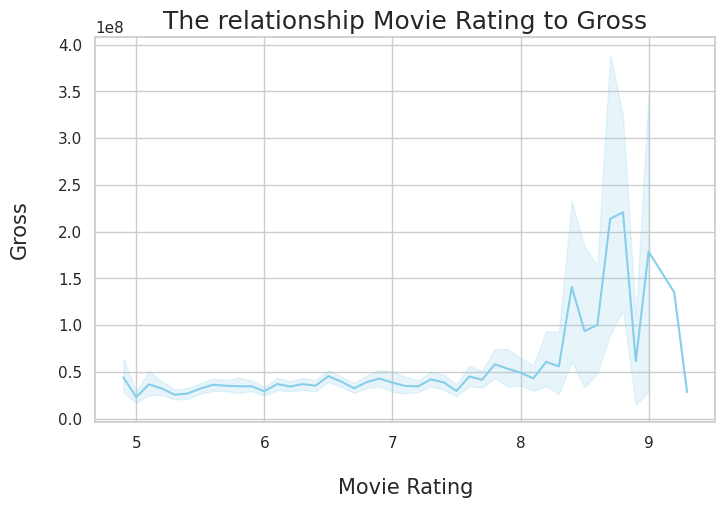

In [ ]:
#the ratio of Movie Rating to Gross
#1e8 == 100,000,000
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

sns.lineplot(data=filtered_data, x='Movie Rating', y='Gross', color="skyblue")

plt.title("The relationship Movie Rating to Gross", fontsize=18)
plt.xlabel('Movie Rating', fontsize=15, labelpad=20)
plt.ylabel('Gross', fontsize=15, labelpad=20)

Text(0, 0.5, 'Gross')

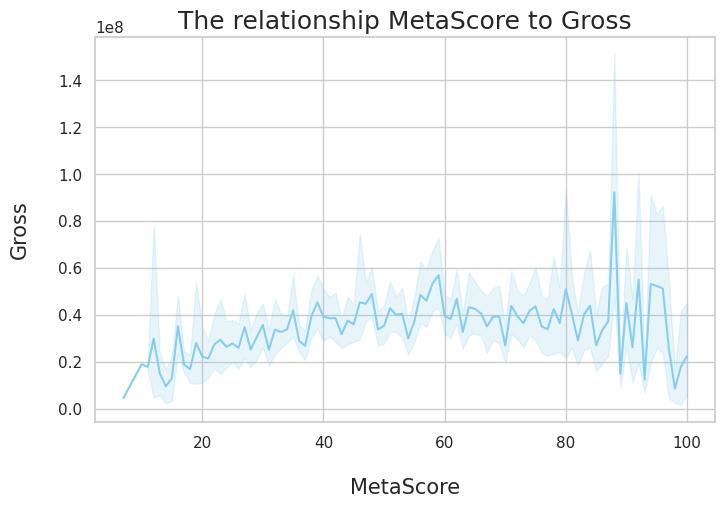

In [ ]:
#the ratio of MetaScore to Gross
#1e8 == 100,000,000
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

sns.lineplot(data=filtered_data, x='MetaScore', y='Gross', color="skyblue")

plt.title("The relationship MetaScore to Gross", fontsize=18)
plt.xlabel('MetaScore', fontsize=15, labelpad=20)
plt.ylabel('Gross', fontsize=15, labelpad=20)

Text(0.5, 1.0, "The impact of a film's Rating on Gross")

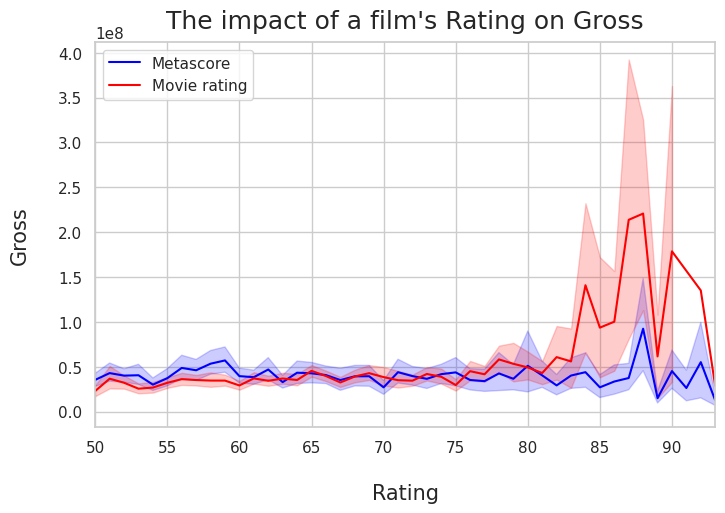

In [ ]:
#the ratio of Movie Rating/MetaScore to Gross(which rating more accurately predicts the gross)
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

movie_mult_ten = filtered_data['Movie Rating'] * 10

sns.lineplot(data=filtered_data, x=filtered_data['MetaScore'], y='Gross', color='blue', label='Metascore')
sns.lineplot(data=filtered_data, x=movie_mult_ten, y='Gross', color='red', label='Movie rating')

plt.xlim(50, 93)
plt.legend(loc="upper left")
plt.xlabel('Rating', fontsize=15, labelpad=20)
plt.ylabel('Gross', fontsize=15, labelpad=20)
plt.title("The impact of a film's Rating on Gross", fontsize=18, pad=10)

### Genre visualisation

In [ ]:
df_genre = df[['Movie Name', 'Gross', 'Genre', 'Certification', 'Movie Rating', 'MetaScore']]
df_genre['Genre'] = df_genre['Genre'].apply(lambda x: [genre.strip(" '") for genre in ast.literal_eval(x)])
df_genre = df_genre.explode('Genre')
df_genre_has_gross = df[df['Has gross'] == True]
df_genre_has_gross['Genre'] = df_genre_has_gross['Genre'].apply(lambda x: [genre.strip(" '") for genre in ast.literal_eval(x)])
df_genre_has_gross = df_genre_has_gross.explode('Genre')

Text(0, 0.5, 'Count films')

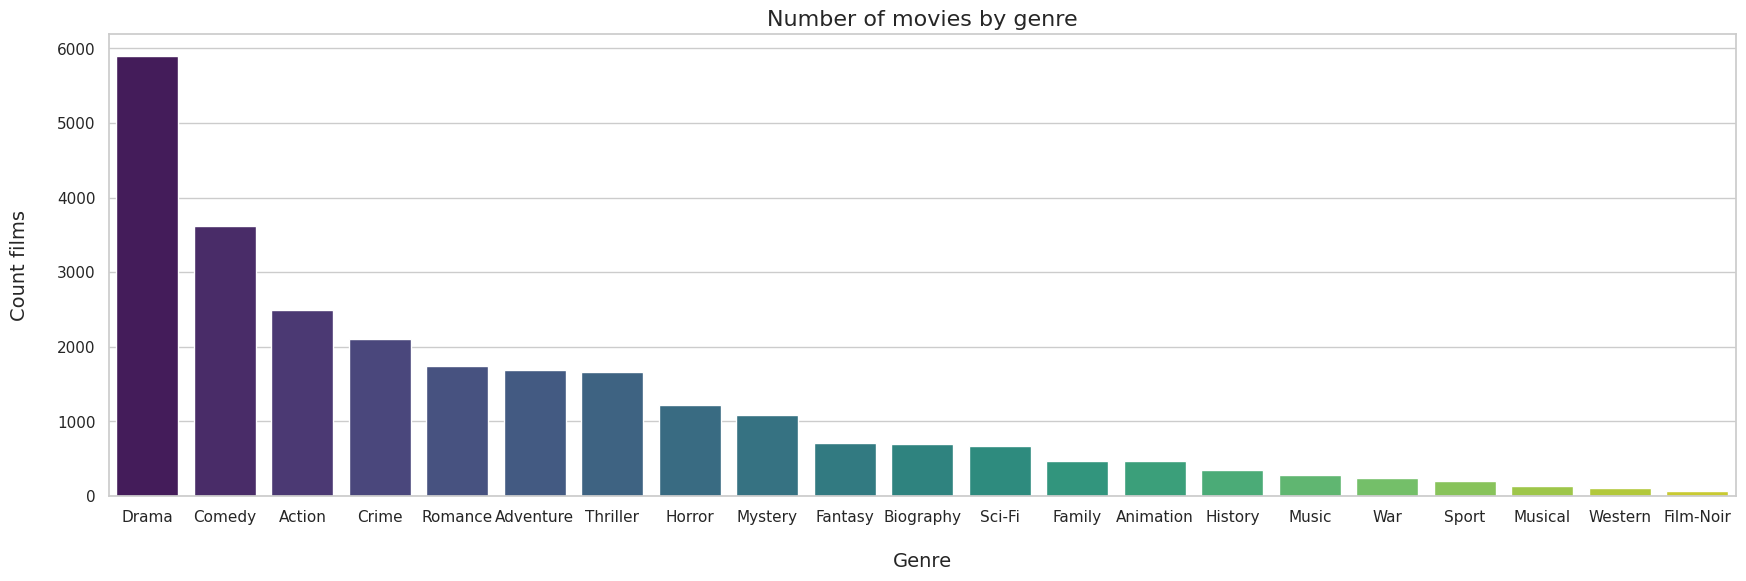

In [348]:
#number of movies by genre
sns.set(style="whitegrid")
plt.figure(figsize=(21, 6))

genre_counts = df_genre['Genre'].value_counts()

sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')

plt.title("Number of movies by genre", fontsize=16)
plt.xlabel('Genre', fontsize=14, labelpad=20)
plt.ylabel('Count films', fontsize=14, labelpad=20)

Text(0, 0.5, 'Genre')

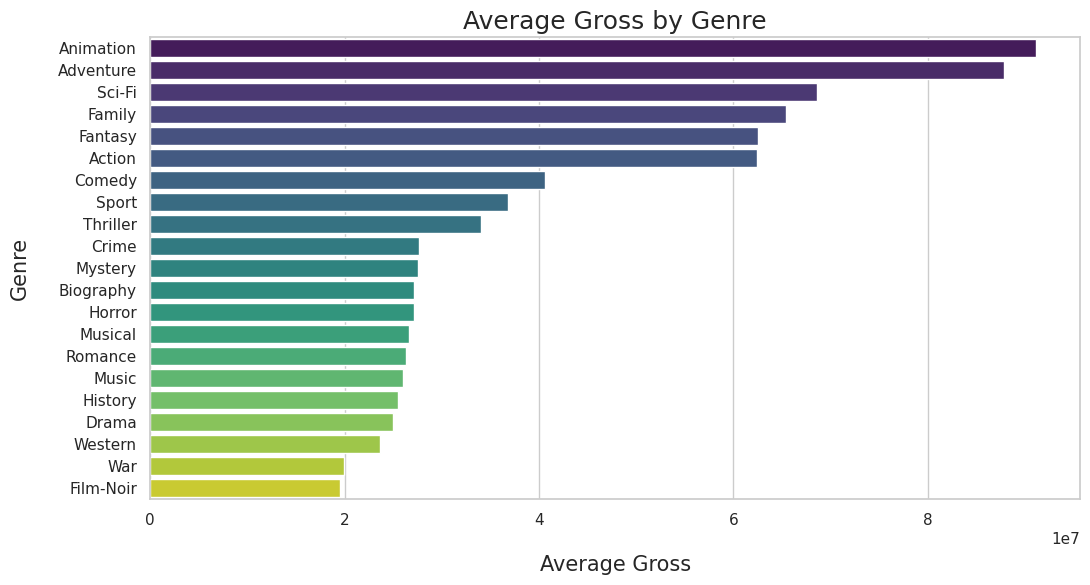

In [ ]:
#which genre is more profitable
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

average_profit_by_genre = df_genre_has_gross.groupby('Genre')['Gross'].mean().reset_index()
average_profit_by_genre = average_profit_by_genre.sort_values(by="Gross", ascending=False)

sns.barplot(data=average_profit_by_genre, x='Gross', y='Genre', palette='viridis')

plt.title("Average Gross by Genre", fontsize=18)
plt.xlabel('Average Gross', fontsize=15, labelpad=20)
plt.ylabel('Genre', fontsize=15, labelpad=20)

Text(0, 0.5, 'Genre')

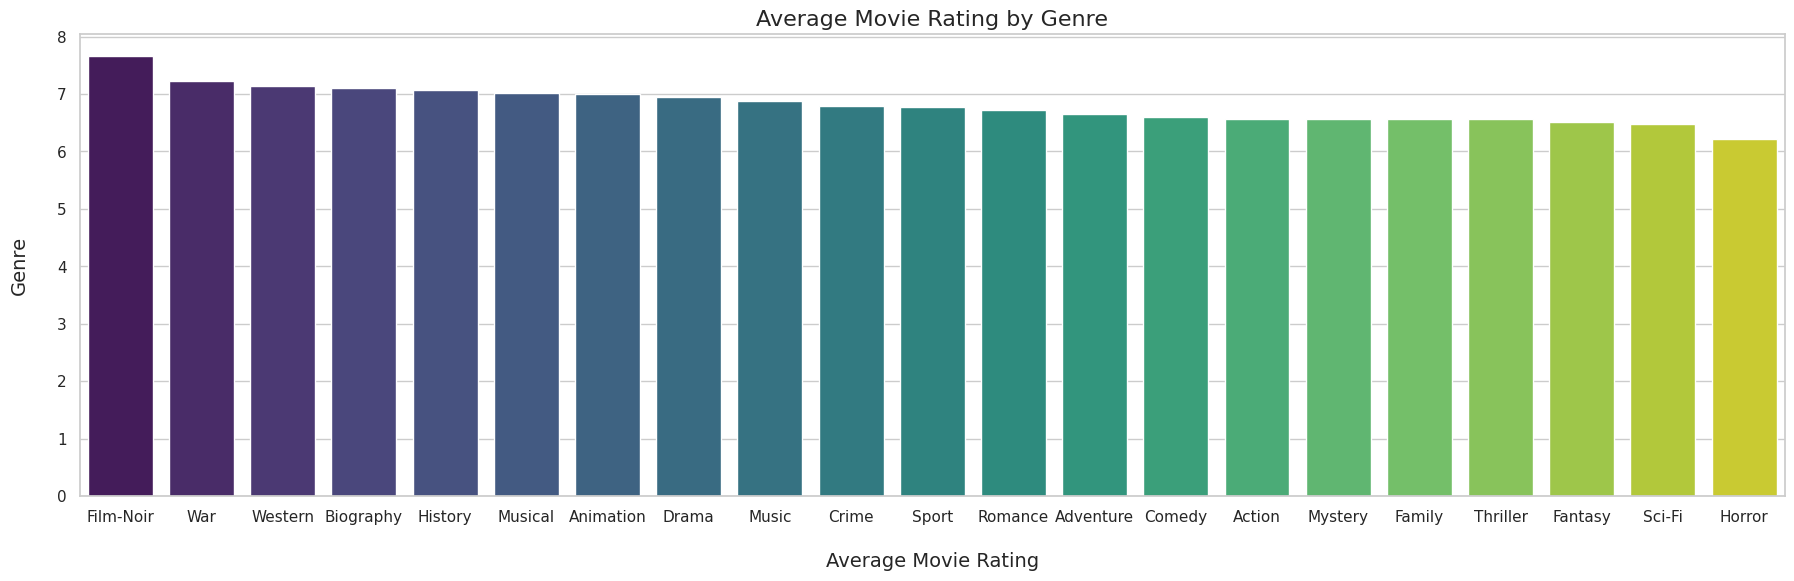

In [349]:
#average Movie Rating by Genre
sns.set(style="whitegrid")
plt.figure(figsize=(22, 6))

rating_by_genre = df_genre.groupby('Genre')['Movie Rating'].mean().reset_index()
rating_by_genre = rating_by_genre.sort_values(by="Movie Rating", ascending=False)

sns.barplot(data=rating_by_genre, x='Genre', y='Movie Rating', palette='viridis')

plt.title("Average Movie Rating by Genre", fontsize=16)
plt.xlabel('Average Movie Rating', fontsize=14, labelpad=20)
plt.ylabel('Genre', fontsize=14, labelpad=20)

Text(166.25, 0.5, 'Certification')

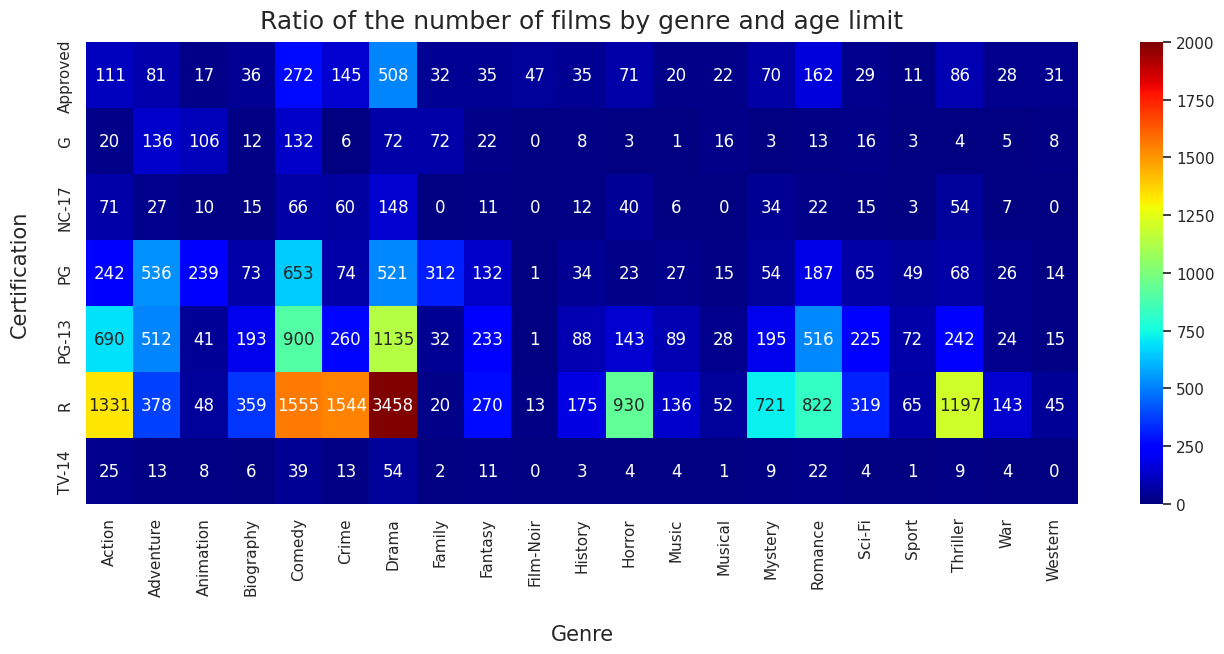

In [ ]:
#ratio of the number of films by genre and age limit
genre_certificate_count = df_genre.groupby(['Certification', 'Genre']).size().unstack().fillna(0)

plt.figure(figsize=(16, 6))

sns.heatmap(genre_certificate_count, cmap='jet', annot=True, fmt='g', vmax=2000)

plt.title("Ratio of the number of films by genre and age limit", fontsize=18, pad=10)
plt.xlabel('Genre', fontsize=15, labelpad=20)
plt.ylabel('Certification', fontsize=15, labelpad=20)

### Directors visualisation

In [ ]:
df_directors = df[['Movie Name', 'Gross', 'Certification', 'Director', 'Movie Rating', 'MetaScore']]
df_directors['Director'] = df_directors['Director'].apply(lambda x: [directors.strip(" '") for directors in ast.literal_eval(x)])
df_directors = df_directors.explode('Director')

Text(0, 0.5, 'Director')

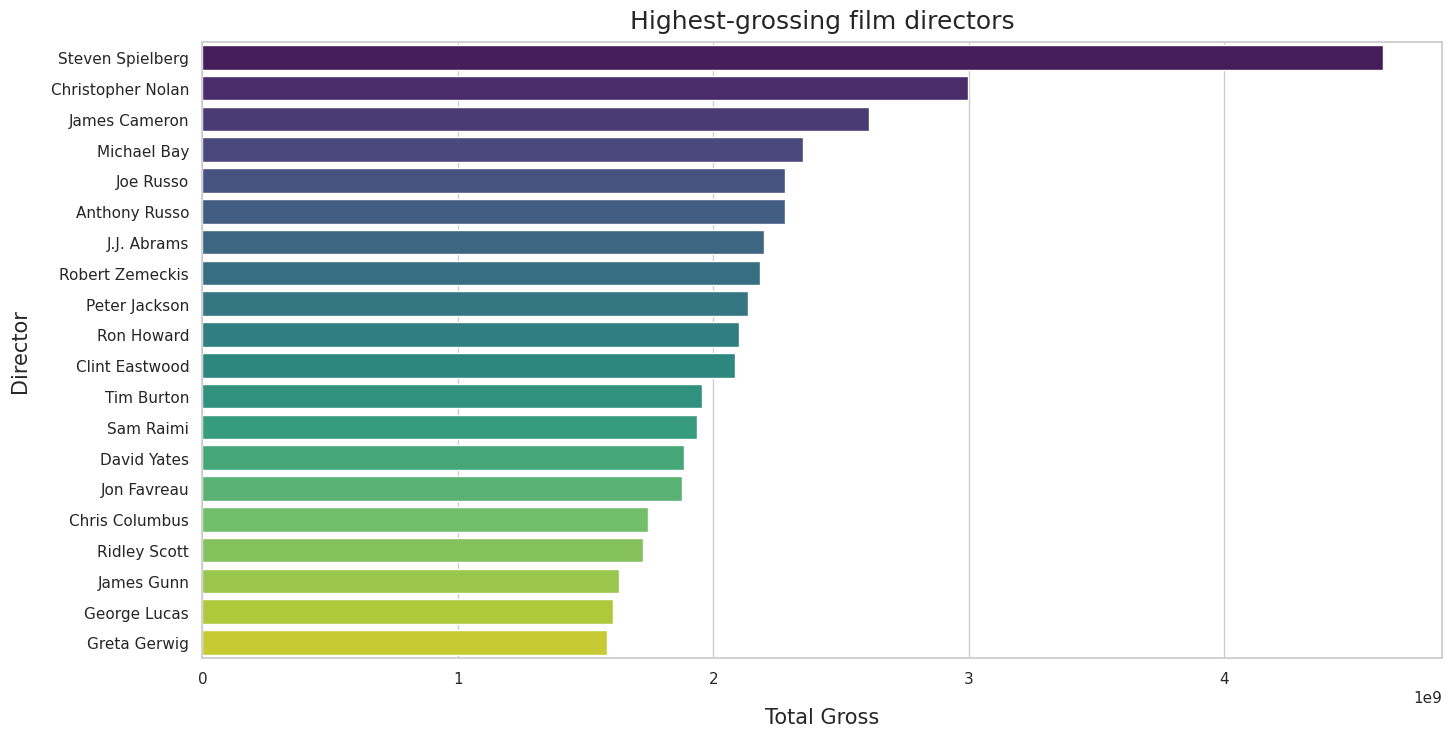

In [357]:
#the highest-grossing film directors
sns.set(style="whitegrid")
plt.figure(figsize=(16, 8))

directors_data = df_directors['Director'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
total_gross_by_director = df_directors.groupby(directors_data)['Gross'].sum()

top_directors = total_gross_by_director.sort_values(ascending=False).head(20)

sns.barplot(x=top_directors.values, y=top_directors.index, palette='viridis')

plt.title("Highest-grossing film directors", fontsize=18, pad=10)
plt.xlabel('Total Gross', fontsize=15, labelpad=15)
plt.ylabel('Director', fontsize=15, labelpad=15)

Text(0, 0.5, 'Director')

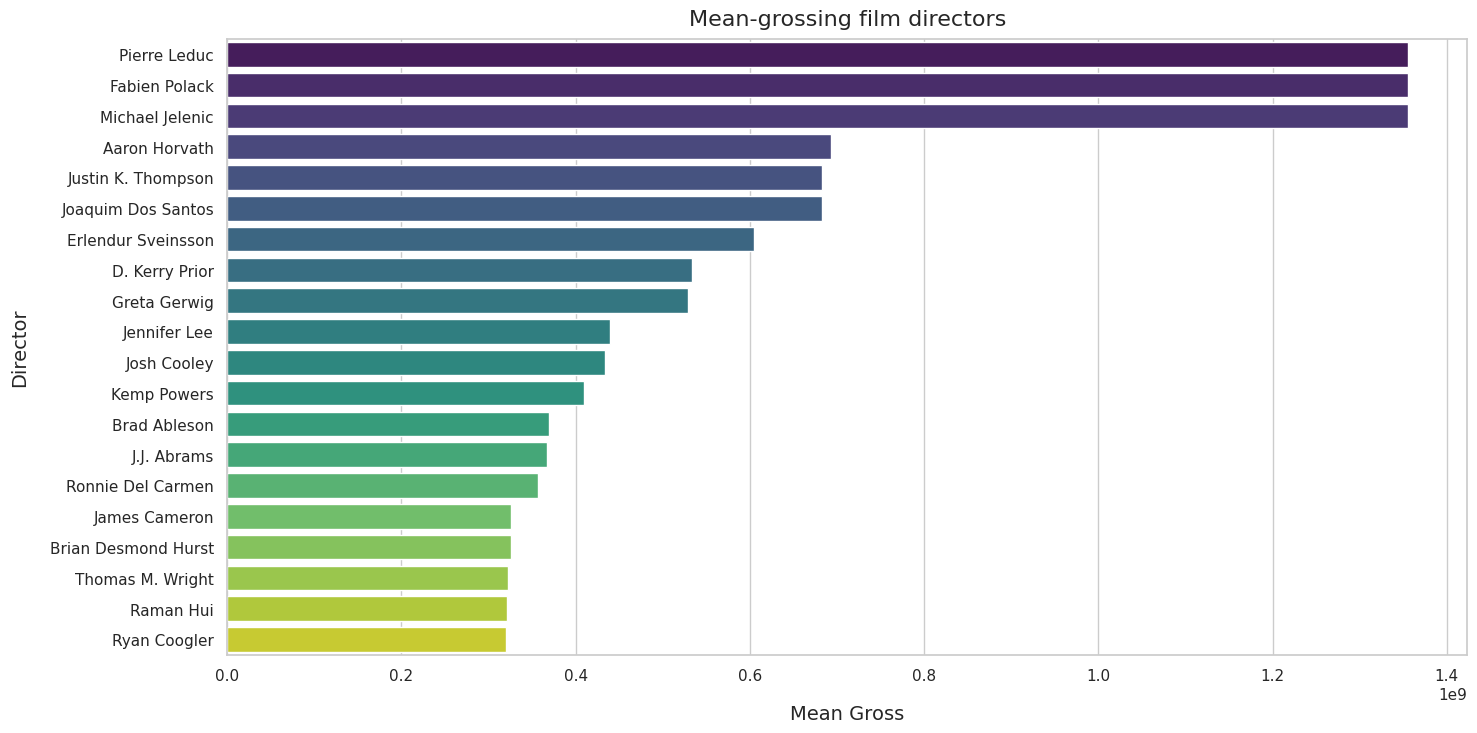

In [351]:
#Mean-grossing film directors
sns.set(style="whitegrid")
plt.figure(figsize=(16, 8))

directors_data = df_directors['Director'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
mean_gross_by_director = df_directors.groupby(directors_data)['Gross'].mean()

top_directors = mean_gross_by_director.sort_values(ascending=False).head(20)

sns.barplot(x=top_directors.values, y=top_directors.index, palette='viridis')

plt.title("Mean-grossing film directors", fontsize=16, pad=10)
plt.xlabel('Mean Gross', fontsize=14, labelpad=15)
plt.ylabel('Director', fontsize=14, labelpad=15)

Text(0, 0.5, 'Director')

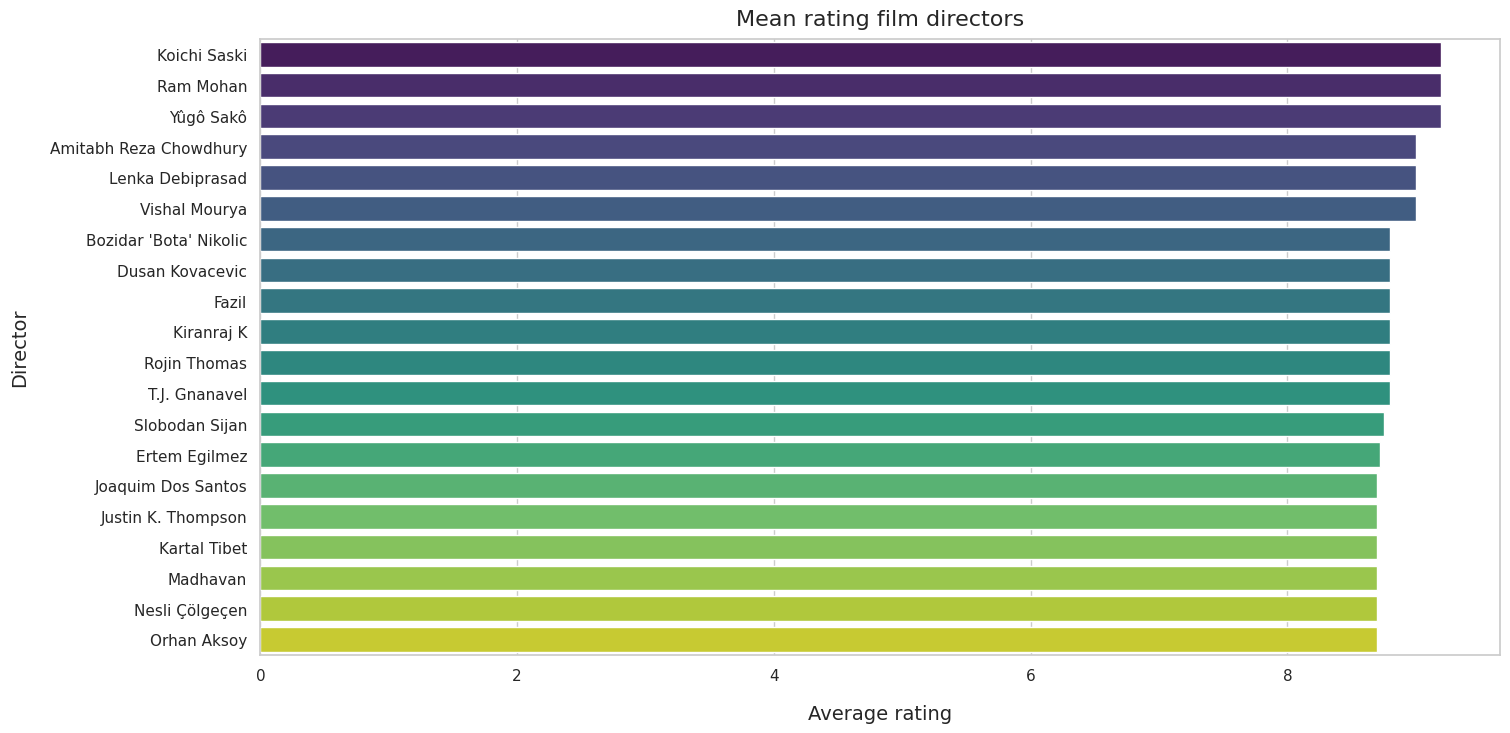

In [352]:
#Mean-rating film directors
sns.set(style="whitegrid")
plt.figure(figsize=(16, 8))

top_directors_by_rating = df_directors.groupby('Director')['Movie Rating'].mean().nlargest(20)

sns.barplot(x=top_directors_by_rating.values, y=top_directors_by_rating.index, palette='viridis')

plt.title("Mean rating film directors", fontsize=16, pad=10)
plt.xlabel('Average rating', fontsize=14, labelpad=15)
plt.ylabel('Director', fontsize=14, labelpad=15)

### Stars visualisation

In [ ]:
df_stars = df[['Movie Name', 'Gross', 'Certification', 'Stars', 'Movie Rating', 'MetaScore']]

df_stars['Stars'] = df_stars['Stars'].apply(lambda x: [stars.strip(" '") for stars in ast.literal_eval(x)])
df_stars = df_stars.explode('Stars')

Text(0, 0.5, 'Stars')

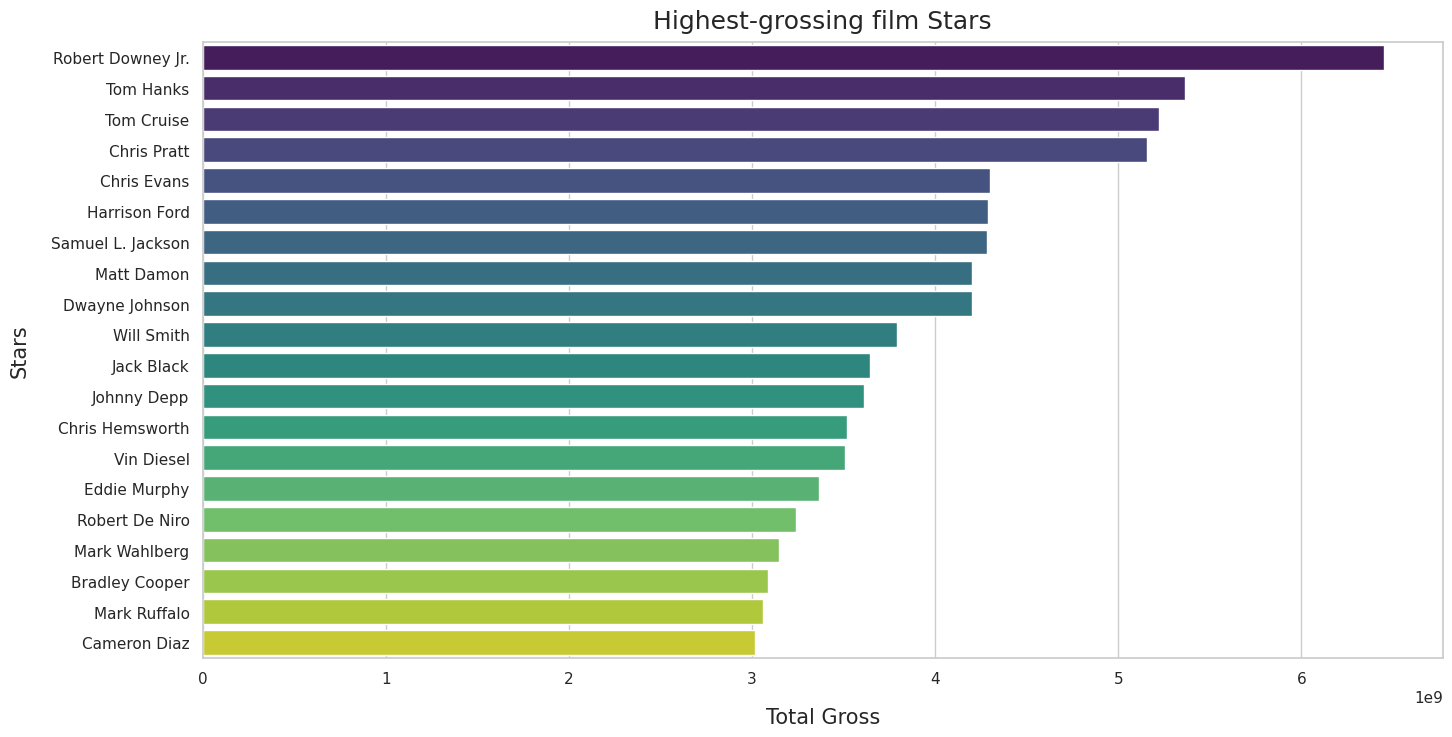

In [356]:
#the highest-grossing film stars
sns.set(style="whitegrid")
plt.figure(figsize=(16, 8))

stars_data = df_stars['Stars'].str.split(', ').explode()
total_gross_by_stars = df_stars.groupby(stars_data)['Gross'].sum()

top_stars = total_gross_by_stars.sort_values(ascending=False).head(20)

sns.barplot(x=top_stars.values, y=top_stars.index, palette='viridis')

plt.title("Highest-grossing film Stars", fontsize=18, pad=10)
plt.xlabel('Total Gross', fontsize=15, labelpad=15)
plt.ylabel('Stars', fontsize=15, labelpad=15)

In [ ]:
#mean grossing film stars
sns.set(style="whitegrid")
plt.figure(figsize=(16, 8))

stars_data = df_stars['Stars'].str.split(', ').explode()
total_gross_by_stars = df_stars.groupby(stars_data)['Gross'].mean()

top_stars = total_gross_by_stars.sort_values(ascending=False).head(20)

sns.barplot(x=top_stars.values, y=top_stars.index, palette='viridis')

plt.title("Mean grossing film Stars", fontsize=16, pad=10)
plt.xlabel('Mean Gross', fontsize=14, labelpad=15)
plt.ylabel('Stars', fontsize=14, labelpad=15)

In [ ]:
#Mean rating film stars
sns.set(style="whitegrid")
plt.figure(figsize=(16, 8))

top_stars_by_rating = df_stars.groupby('Stars')['Movie Rating'].mean().nlargest(20)

sns.barplot(x=top_stars_by_rating.values, y=top_stars_by_rating.index, palette='viridis')

plt.title("Mean rating film stars", fontsize=16, pad=10)
plt.xlabel('Average rating', fontsize=14, labelpad=15)
plt.ylabel('Director', fontsize=14, labelpad=15)

### Other visualisation

<ipython-input-359-f67ca832a3ba>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_correlation.corr()


Text(0.5, 1.0, 'Сorrelation matrix')

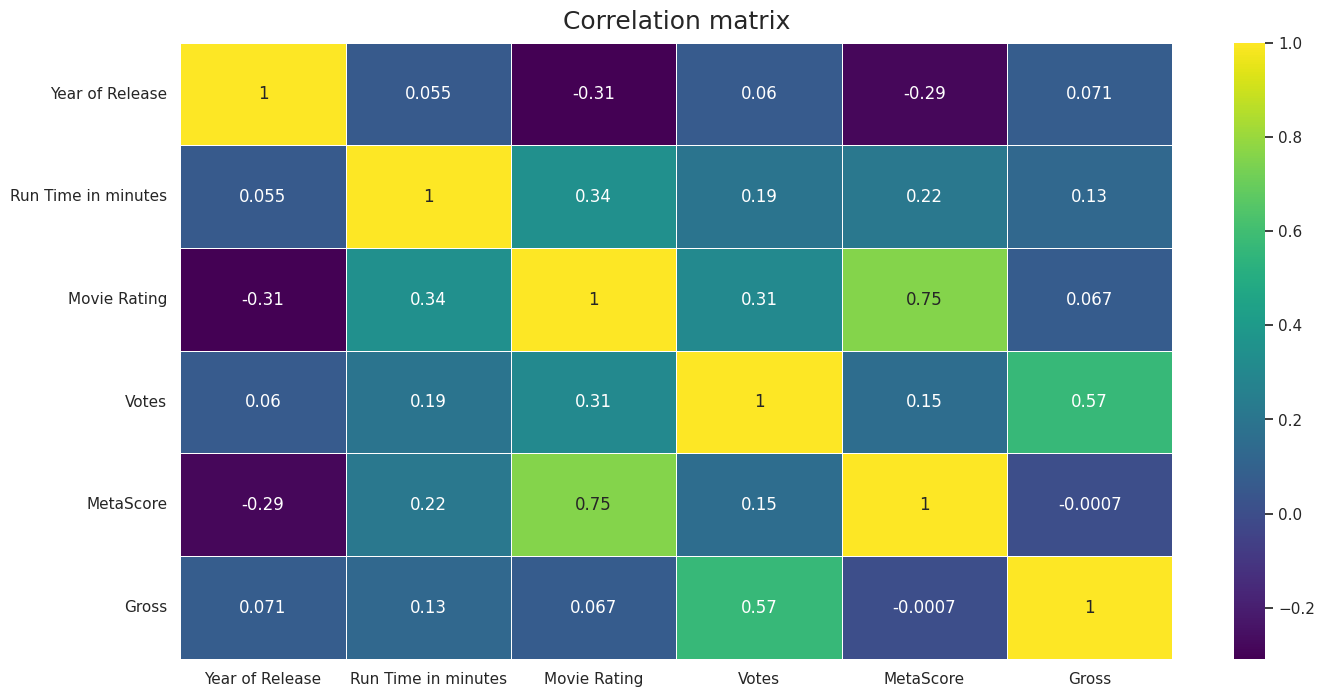

In [359]:
#correlation_matrix

df_correlation = df
df_correlation = df_correlation.drop('Number', axis=1)
df_correlation = df_correlation.drop('Has gross', axis=1)
correlation_matrix = df_correlation.corr()

plt.figure(figsize=(16, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', linewidths=.5)

plt.title("Сorrelation matrix", fontsize=18, pad=10)

In [1]:
print("Hello World!!!")

Hello World!!!
